In [2]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 15.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 48.9MB/s 
     |████████████████████████████████| 512kB 39.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=98b7fe38b65c85725a4cfd45b3bb9d080856f54bd338afaa4195b2ed8947ea88
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

data = pd.read_csv(r"/content/drive/MyDrive/Data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
print(data.tail(10))

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None




words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
tags = list(set(data["Tag"].values))
n_tags = len(tags)
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)
sentences = getter.sentences
max_len = 50
tag2idx = {t: i for i, t in enumerate(tags)}
X = [[w[0] for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X
print(X[1])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print(y[1])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)
batch_size = 32
sess = tf.Session()
K.set_session(sess)


Using TensorFlow backend.


              Sentence #       Word  POS    Tag
1048565  Sentence: 47958     impact   NN      O
1048566  Sentence: 47958          .    .      O
1048567  Sentence: 47959     Indian   JJ  B-gpe
1048568  Sentence: 47959     forces  NNS      O
1048569  Sentence: 47959       said  VBD      O
1048570  Sentence: 47959       they  PRP      O
1048571  Sentence: 47959  responded  VBD      O
1048572  Sentence: 47959         to   TO      O
1048573  Sentence: 47959        the   DT      O
1048574  Sentence: 47959     attack   NN      O
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]
['Iranian', 'officials', 'say', 'they', 'expect', 'to', 'get', 'access', 

In [5]:

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())


In [6]:

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, 'string')),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

input_text = Input(shape=(max_len,), dtype='string')
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val), 
                 batch_size=batch_size, epochs=3, verbose=1) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 38816 samples, validate on 4320 samples
Epoch 1/3
38816/38816 [==============================] - 389s 10ms/step - loss: 0.0629 - accuracy: 0.9818 - val_loss: 0.0448 - val_accuracy: 0.9860
Epoch 2/3
38816/38816 [==============================] - 378s 10ms/step - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.0420 - val_accuracy: 0.9864
Epoch 3/3
38816/38816 [==============================] - 377s 10ms/step - loss: 0.0345 - accuracy: 0.9883 - val_loss: 0.0407 - val_accuracy: 0.9871


In [8]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-org (B-org)
Government     :I-org (I-org)
Accountability :I-org (O)
office         :O     (O)
,              :O     (O)
The            :B-org (B-org)
New            :I-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :I-tim (O)
Iraq           :B-geo (B-geo)
's             :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :O     (O)
the            :O     (O)
pa

In [14]:
import pickle
pickle.dump(model, open('model', 'wb'))

In [10]:
hist = pd.DataFrame(history.history)


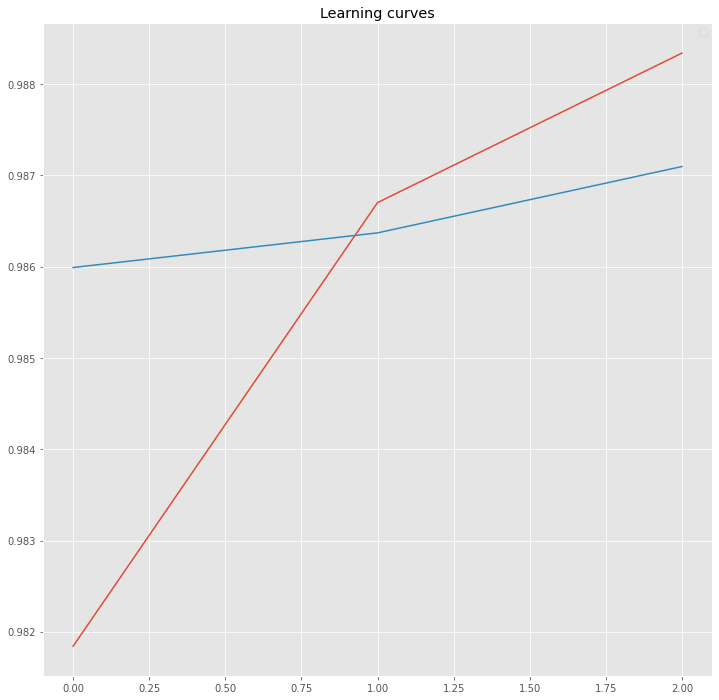

In [11]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curves")
plt.legend()
plt.show()


In [15]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=877da62b47679bdf9103107494731583b6c44b5287b76f6ef845692b508816c0
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [17]:

words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [18]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [19]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [21]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)
idx2tag = {i: w for w, i in tag2idx.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])
print(classification_report(test_labels, pred_labels))

4768/4768 [==============================] - 32s 7ms/step
              precision    recall  f1-score   support

         art       0.50      0.10      0.17        49
         eve       0.20      0.24      0.22        33
         geo       0.83      0.90      0.87      3720
         gpe       0.97      0.93      0.95      1591
         nat       0.35      0.27      0.31        22
         org       0.70      0.66      0.68      2061
         per       0.76      0.79      0.77      1677
         tim       0.87      0.86      0.86      2148

   micro avg       0.82      0.83      0.83     11301
   macro avg       0.65      0.59      0.60     11301
weighted avg       0.82      0.83      0.82     11301

